.. _props_ech3:

# Properties: Charge Density (ECH3)

The :py:class:`~.aiida_crystal17.calculations.prop_ech3.CryEch3Calculation` can be used to run the `properties`
executable for ECH3 calculations, from an existing `fort.9`.

.. seealso::

    :ref:`props_workflow` to run multiple properties calculations
    (and optional initial SCF).

In [1]:
!verdi plugin list aiida.calculations crystal17.ech3

Inputs
           code:  required  Code                                    The Code to use for this job.
     parameters:  required  Dict                                    the input parameters to create the properties input file.
      wf_folder:  required  FolderData, RemoteData, SinglefileData  the folder containing the wavefunction fort.9 file
       metadata:  optional                                          
Outputs
         charge:  required  GaussianCube                            The charge density cube
  remote_folder:  required  RemoteData                              Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dict                                    Summary Data extracted from the output file(s)
      retrieved:  required  FolderData                              Files that are retrieved by the daemon will be stored in this node. By defa ...
           spin:  optional  GaussianCube                            Th

In [2]:
from aiida import engine, load_profile, orm, plugins
from aiida.tools.visualization import Graph
from aiida_crystal17.common import recursive_round
from aiida_crystal17.tests.utils import (
    get_or_create_local_computer, get_or_create_code,
    get_default_metadata)
from aiida_crystal17.tests import open_resource_binary
profile = load_profile()
profile.name

'test_crystal17'

## Running a calculation

The :ref:`ech3_input_schema` gives the allowed format of the input dictionary, for example:

In [4]:
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.ech3', computer, 'mock_properties17')

builder = code.get_builder()
builder.metadata = get_default_metadata()
builder.parameters = orm.Dict(dict={
    'npoints': 20
})
with open_resource_binary('ech3', 'mgo_sto3g_scf', 'fort.9') as handle:
    builder.wf_folder = orm.SinglefileData(handle)

In [5]:
result, calcnode = engine.run_get_node(builder)

In [6]:
!verdi process show {calcnode.pk}

Property       Value
-------------  ------------------------------------
type           CalcJobNode
pk             974
uuid           4dd70b8f-e7b6-4684-84e2-69f5db4ddbb8
label
description
ctime          2019-09-24 15:45:47.628170+00:00
mtime          2019-09-24 15:46:01.609931+00:00
process state  Finished
exit status    0
computer       [1] localhost

Inputs        PK  Type
----------  ----  --------------
code         971  Code
parameters   972  Dict
wf_folder    973  SinglefileData

Outputs          PK  Type
-------------  ----  ------------
charge          978  GaussianCube
remote_folder   975  RemoteData
results         977  Dict
retrieved       976  FolderData


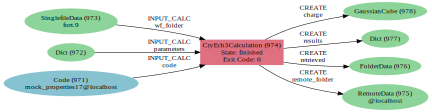

In [7]:
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode)
graph.add_incoming(calcnode, annotate_links="both")
graph.add_outgoing(calcnode, annotate_links="both")
graph.graphviz

## Analysing the outputs

The outputs are:

- **results** a dict of computation input and output parameters, parsed from the stdout file.
- **charge** a data node containing the gaussian cube file for the charge density.
- **spin** a data node containing the gaussian cube file for the spin density (if the original computation included spin).

In [8]:
recursive_round(calcnode.outputs.results.get_dict(), 1)

{'units': {'energy': 'eV', 'conversion': 'CODATA2014'},
 'errors': [],
 'header': {'crystal_version': 17, 'crystal_subversion': '1.0.1'},
 'warnings': [],
 'wf_input': {'n_ao': 14,
  'n_atoms': 2,
  'k_points': [8, 8, 8],
  'n_shells': 5,
  'n_symops': 48,
  'gilat_net': 8,
  'n_core_el': 12,
  'n_electrons': 20,
  'energy_fermi': -4.0,
  'energy_total': -7380.2,
  'n_kpoints_ibz': 29,
  'energy_kinetic': 7269.0},
 'parser_class': 'CryEch3Parser',
 'parser_errors': [],
 'parser_version': '0.10.0b5',
 'parser_exceptions': [],
 'execution_time_seconds': 0}

The :py:class:`~aiida_crystal17.data.gcube.GaussianCube` data node stores a [gaussian cube](http://h5cube-spec.readthedocs.io/en/latest/cubeformat.html) in a compressed zip file.

In [12]:
calcnode.outputs.charge.attributes

{'cell': [[0.0, 2.2157919831613, 2.2157919831613],
  [2.2157919831613, 0.0, 2.2157919831613],
  [2.2157919831613, 2.2157919831613, 0.0]],
 'units': {'length': 'angstrom', 'conversion': 'CODATA2014'},
 'header': ['Charge density - 3D GRID - GAUSSIAN CUBE FORMAT MgO Bulk',
  '5.62556267     5.62556267     5.62556267    60.000000  60.000000  60.000000'],
 'elements': ['Mg', 'O'],
 'voxel_grid': [20, 20, 20],
 'zip_filename': 'gcube.zip',
 'cube_filename': 'gaussian.cube',
 'compression_method': 8}

The full file can be accessed *via*:

In [13]:
with calcnode.outputs.charge.open_cube_file() as handle:
    print(handle.readline())

 Charge density - 3D GRID - GAUSSIAN CUBE FORMAT MgO Bulk                      



There is also methods available to parse the file to a dict or structure:

In [16]:
data = calcnode.outputs.charge.get_cube_data()
data.atoms_atomic_number

[12, 8]

In [17]:
calcnode.outputs.charge.get_ase()

Atoms(symbols='MgO', pbc=True, cell=[[0.0, 2.2157919831613384, 2.2157919831613384], [2.2157919831613384, 0.0, 2.2157919831613384], [2.2157919831613384, 2.2157919831613384, 0.0]])

Some experimental methods also exist, for basic analysis of the density.

In [18]:
calcnode.outputs.charge.compute_integration_cell()

18.60283258916424

In [24]:
calcnode.outputs.charge.compute_integration_atom([0, 1], radius=1.0)

[17.16956646407823, 1.1837163766941237]

## Visualising the density in VESTA

The :py:mod:`~aiida_crystal17.parsers.raw.gcube_to_vesta` module
contains functions, to convert cube data to input files that can be opened in [VESTA](http://jp-minerals.org/vesta).
The :ref:`vesta_input_schema` gives the allowed format of the input settings dictionary, for example:

In [38]:
from aiida.common.folders import SandboxFolder
from aiida_crystal17.parsers.raw.gcube_to_vesta import (
    create_vesta_input, write_vesta_files)

settings = {
    "2d_display": {
        "h": 1.0,
        "k": -1.0,
        "l": 0.0,
        "dist_from_o": 0.0
    }
}

with SandboxFolder() as folder:
        write_vesta_files(
            calcnode.outputs.charge, 
            folder.abspath, 'mgo', settings)
        print(folder.get_content_list())
        with folder.open('mgo.vesta') as handle:
            print(handle.read()[:100])

['mgo.cube', 'mgo.vesta']
#VESTA_FORMAT_VERSION 3.3.0

CRYSTAL

TITLE
GAUSSIAN_CUBE_DATA

IMPORT_DENSITY 1
+1.000000 mgo.cube



![VESTA 3D Density Visualisation](vesta_screenshots/main.png)

![VESTA 2D Density Visualisation](vesta_screenshots/2d_display.png)